In [2]:
pip install wandb

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 19.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 248.6 MB/s eta 0:00:00
DEPRECATION: devscripts 2.22.1ubuntu1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of devscripts or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
from pathlib import Path
import torch
import wandb
from torch import nn

from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import transforms

In [2]:
import multiprocessing

def get_num_cpu_cores():
    """CPU 코어 수를 반환"""
    return multiprocessing.cpu_count()

def is_linux():
    """Linux 시스템인지 확인"""
    return os.name == "posix"

def is_windows():
    """Windows 시스템인지 확인"""
    return os.name == "nt"

In [3]:
DATA_PATH ="./j_fashion_mnist"
os.makedirs(DATA_PATH, exist_ok=True)

In [4]:
def get_fashion_mnist_data():
    #데이터셋이 저장될 path 지정
    #데이터 셋 다운로드 (해당 경로에 데이터셋이 없다면 download 실행)
    #데이터 셋 분할 -> 훈련/ 검증
    data_path = os.path.join(DATA_PATH)

    f_mnist_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transforms.ToTensor())
    f_mnist_train, f_mnist_validation = random_split(f_mnist_train, [55_000, 5_000])

    print("Num Train Samples: ", len(f_mnist_train))
    print("Num Validation Samples: ", len(f_mnist_validation))
    print("Sample Shape: ", f_mnist_train[0][0].shape)  # torch.Size([1, 28, 28])

    num_data_loading_workers = get_num_cpu_cores() if is_linux() or is_windows() else 0
    print("Number of Data Loading Workers:", num_data_loading_workers)

    # 훈련 데이터셋 로더 생성
    train_data_loader = DataLoader(
        dataset=f_mnist_train, batch_size=wandb.config.batch_size, shuffle=True,
        pin_memory=True, num_workers=num_data_loading_workers
    )
    # 검증 데이터셋 로더 생성
    validation_data_loader = DataLoader(
        dataset=f_mnist_validation, batch_size=wandb.config.batch_size,
        pin_memory=True, num_workers=num_data_loading_workers
    )

    # 이미지에 대한 정규화 실시(1번 문제 : FashionMnist 데이터셋의 평균과 표준 편차를 구하여 적용시키기)
    f_mnist_transforms = nn.Sequential(
        transforms.ConvertImageDtype(torch.float),
        # 구해진 평균값과 표준편차값 입력
        transforms.Normalize(mean=0.2860, std=0.3530),
    )
    return train_data_loader, validation_data_loader, f_mnist_transforms

In [5]:
def calculate_mean_std(dataset):
    """
    데이터셋의 평균(mean)과 표준편차(std)를 계산하는 함수
    :param dataset: 데이터셋 (FashionMNIST)
    :return: 평균(mean), 표준편차(std)
    """
    data_loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    # 데이터셋을 한 번에 모두 로드
    data = next(iter(data_loader))[0]  # 이미지 데이터만 가져옴
    data = data.view(data.size(0), -1)  # (batch_size, channels, height, width) -> (batch_size, all_pixels)

    mean = data.mean()  # 전체 픽셀의 평균 계산
    std = data.std()  # 전체 픽셀의 표준편차 계산
    print(mean,std)
    return mean.item(), std.item()

In [6]:
def get_fashion_mnist_test_data():
    data_path = os.path.join(DATA_PATH)

    f_mnist_test_images = datasets.FashionMNIST(data_path, train=False, download=True)
    f_mnist_test = datasets.FashionMNIST(data_path, train=False, download=True, transform=transforms.ToTensor())

    print("Num Test Samples: ", len(f_mnist_test))
    print("Sample Shape: ", f_mnist_test[0][0].shape)  # torch.Size([1, 28, 28])

    test_data_loader = DataLoader(dataset=f_mnist_test, batch_size=len(f_mnist_test))

    f_mnist_transforms = nn.Sequential(
        transforms.ConvertImageDtype(torch.float),
        # 구해진 평균값과 표준편차값 사용
        transforms.Normalize(mean=0.2860, std=0.3530),
    )

    return f_mnist_test_images, test_data_loader, f_mnist_transforms

# 문제 1번. FashionMNIST 데이터의 평균값과 표준편차값을 구하여 정규화 하시오

In [7]:
data_path = os.path.join(DATA_PATH)
f_mnist_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transforms.ToTensor())

# 평균과 표준편차 계산
mean, std = calculate_mean_std(f_mnist_train)
print(f"Mean: {mean}, Std: {std}")
# 계산시 mean : 0.2860  std : 0.3530 도출

tensor(0.2860) tensor(0.3530)
Mean: 0.28604060411453247, Std: 0.3530242443084717


In [8]:
if __name__ == "__main__":

    config = {'batch_size': 2048, }
    wandb.init(mode="disabled", config=config)

    train_data_loader, validation_data_loader, f_mnist_transforms = get_fashion_mnist_data()
    print()
    f_mnist_test_images, test_data_loader, f_mnist_transforms = get_fashion_mnist_test_data()

Num Train Samples:  55000
Num Validation Samples:  5000
Sample Shape:  torch.Size([1, 28, 28])
Number of Data Loading Workers: 2

Num Test Samples:  10000
Sample Shape:  torch.Size([1, 28, 28])


In [9]:
from torch import optim
from datetime import datetime
import wandb
import sys

In [26]:
def get_vgg_model():
    def vgg_block(num_conv_layers, out_channels):
        layers = []
        for _ in range(num_conv_layers):
            layers.append(nn.LazyConv2d(out_channels=out_channels, kernel_size=3, padding=1))
            layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))  # MaxPooling
        block = nn.Sequential(*layers)
        return block

    class VGG(nn.Module):
        def __init__(self, block_info, n_output=10):
            super().__init__()
            conv_blocks = []
            for (num_conv_layers, out_channels) in block_info:
                conv_blocks.append(vgg_block(num_conv_layers, out_channels))

            self.model = nn.Sequential(
                *conv_blocks,                # CNN Block Stacks
                nn.Flatten(),               # Flatten output
                nn.LazyLinear(512),
                nn.ReLU(),
                nn.Dropout(0.05),             # Dropout for regularization
                nn.LazyLinear(out_features=512),
                nn.ReLU(),
                nn.Dropout(0.05),
                nn.LazyLinear(n_output)      # Final output layer
            )

        def forward(self, x):
            return self.model(x)

    # Define VGG architecture for FashionMNIST
    my_model = VGG(
        block_info=((1, 64), (1, 128), (2, 256)),  # Conv block configuration
        n_output=10  # FashionMNIST has 10 output classes
    )
    return my_model


In [36]:
import torch
import wandb
import torch.nn as nn

def training_loop(model, optimizer, train_data_loader, validation_data_loader, save_path="best_model.pth"):
    n_epochs = wandb.config.epochs  # 반복 횟수
    loss_fn = nn.CrossEntropyLoss()  # 다중 클래스 분류 문제에 적합한 손실 함수
    next_print_epoch = 2  # 2번마다 loss 출력
    best_val_loss = float("inf")  # 초기화된 최적 검증 손실

    for epoch in range(1, n_epochs + 1):
        # Training Phase
        model.train()
        loss_train = 0.0
        num_trains = 0
        correct_train = 0  # Training Accuracy 계산을 위한 변수
        total_train = 0

        for input, target in train_data_loader:
            input, target = input.to("cuda"), target.to("cuda")  # GPU로 전송
            output_train = model(input)  # 모델 예측 (logits)
            loss = loss_fn(output_train, target)  # 손실 계산
            loss_train += loss.item()
            num_trains += 1

            # Training Accuracy 계산
            _, predicted = torch.max(output_train, 1)
            correct_train += (predicted == target).sum().item()
            total_train += target.size(0)

            # Gradient Update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation Phase
        model.eval()
        loss_validation = 0.0
        num_validations = 0
        correct_val = 0  # Validation Accuracy 계산을 위한 변수
        total_val = 0

        with torch.no_grad():
            for input, target in validation_data_loader:
                input, target = input.to("cuda"), target.to("cuda")  # GPU로 전송
                output_validation = model(input)  # 모델 예측
                loss = loss_fn(output_validation, target)  # 손실 계산
                loss_validation += loss.item()
                num_validations += 1

                # Validation Accuracy 계산
                _, predicted = torch.max(output_validation, 1)
                correct_val += (predicted == target).sum().item()
                total_val += target.size(0)

        # 평균 손실 및 정확도 계산
        avg_train_loss = loss_train / num_trains
        avg_val_loss = loss_validation / num_validations
        train_accuracy = correct_train / total_train * 100
        val_accuracy = correct_val / total_val * 100

        # 최적 모델 저장
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), save_path)  # 모델 가중치 저장
            print(f"Best model saved at epoch {epoch} with validation loss {best_val_loss:.4f}")

        # WandB 로그 작성
        wandb.log({
            "Epoch": epoch,
            "Training loss": avg_train_loss,
            "Validation loss": avg_val_loss,
            "Training Accuracy": train_accuracy,
            "Validation Accuracy": val_accuracy,
        })

        # 일정 에포크마다 결과 출력
        if epoch >= next_print_epoch:
            print(
                f"Epoch {epoch}, "
                f"Train Loss: {avg_train_loss:.4f}, "
                f"Val Loss: {avg_val_loss:.4f}, "
                f"Train Accuracy: {train_accuracy:.2f}%, "
                f"Val Accuracy: {val_accuracy:.2f}%"
            )
            next_print_epoch += 2


In [ ]:
wandb.login(key="")  
os.environ['WANDB_API_KEY'] ='119449ae9a5389c4e15624a3fbcf6f30e575f0c4'


In [37]:
def main(args):
    #현재 시간 기록
    current_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    #모델에 설정할 값들을 담은 딕셔너리
    #에포크, 배치사이즈, 러닝 레이트, 히든 유닛 개수 등 포함되어 있음
    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'learning_rate': 1e-3,
    }

    #wandb 모델의 초기값 생성
    wandb.init(
        mode="online" if args.wandb else "disabled",
        project="homework_03_",
        notes="Fashion_Mnist Dataset experiment_5",
        tags=["my_model", "Fashion_Mnist"],
        name=current_time_str,
        config=config
    )
    print(args)
    print(wandb.config)

    #모델과 옵티마이저 생성
    model = get_vgg_model()
    device = "cuda" if torch.cuda.is_available() else "cpu"  # GPU가 있으면 cuda로, 없으면 CPU로 설정

# 모델을 device로 이동
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate)

    print("#" * 50, 1)

    #모델 train 시작.
    training_loop(
        model=model,
        optimizer=optimizer,
        train_data_loader=train_data_loader,
        validation_data_loader=validation_data_loader
    )
    #train 끝


    wandb.finish()
    test_accuracy = test_model(model, test_data_loader, save_path="best_model.pth")
    print(f"Final Test Accuracy: {test_accuracy:.2f}%")

In [ ]:
def test_model(model, test_data_loader, save_path="best_model.pth"):
    # 저장된 모델 가중치 로드
    model.load_state_dict(torch.load(save_path))
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for input, target in test_data_loader:
            input, target = input.to("cuda"), target.to("cuda")
            output = model(input)
            _, predicted = torch.max(output, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

    accuracy = correct / total * 100
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

# ===============================================

# 문제 2, 3번 학습시키기 및 test accurancy 확인하기


In [40]:
if __name__ == "__main__":
    
    class Args:
        wandb = True
        batch_size = 256
        epochs = 50  
        validation_intervals = 10
        early_stop_patience = 10

    args = Args()  # args 추가
    main(args)

{'epochs': 50, 'batch_size': 256, 'learning_rate': 0.001}
################################################## 1
Best model saved at epoch 1 with validation loss 0.8676
Best model saved at epoch 2 with validation loss 0.6639
Epoch 2, Train Loss: 0.7488, Val Loss: 0.6639, Train Accuracy: 71.04%, Val Accuracy: 74.60%
Best model saved at epoch 3 with validation loss 0.5545
Best model saved at epoch 4 with validation loss 0.4771
Epoch 4, Train Loss: 0.5046, Val Loss: 0.4771, Train Accuracy: 80.92%, Val Accuracy: 82.62%
Best model saved at epoch 5 with validation loss 0.4463
Best model saved at epoch 6 with validation loss 0.3852
Epoch 6, Train Loss: 0.3964, Val Loss: 0.3852, Train Accuracy: 85.18%, Val Accuracy: 85.92%
Best model saved at epoch 7 with validation loss 0.3642
Best model saved at epoch 8 with validation loss 0.3411
Epoch 8, Train Loss: 0.3393, Val Loss: 0.3411, Train Accuracy: 87.17%, Val Accuracy: 87.40%
Best model saved at epoch 10 with validation loss 0.3256
Epoch 10, Train 

Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Training Accuracy,▁▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
Training loss,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▃▄▅▆▆▇▇▇▇▇▇▇█▇█████████████████████████
Validation loss,█▆▅▄▃▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▂▂▂▂▂▂
Epoch,50
Training Accuracy,98.62909
Training loss,0.03785
Validation Accuracy,92.26
Validation loss,0.31764


Test Accuracy: 91.54%
Final Test Accuracy: 91.54%


# 이번 시도의 wandb 사진입니다. 
![My Screenshot](C:\Users\lss52\Downloads\VGG_chart_batch256.png)

이번 시도는 batch_size를 256으로 두고 실험을 해본 모습입니다. valdation accurancy는 최고 92.26%가 나오게 되었고, 이번 학습의 test결과 91.54가 나오게 되었습니다. 

In [39]:
if __name__ == "__main__":
    
    class Args:
        wandb = True
        batch_size = 512
        epochs = 50  
        validation_intervals = 10
        early_stop_patience = 10

    args = Args()  # args 추가
    main(args)

wandb: Currently logged in as: lss523012 (lss523012-korea-university-of-technology-and-education). Use `wandb login --relogin` to force relogin


{'epochs': 50, 'batch_size': 512, 'learning_rate': 0.001}
################################################## 1
Best model saved at epoch 1 with validation loss 0.9412
Best model saved at epoch 2 with validation loss 0.6517
Epoch 2, Train Loss: 0.7574, Val Loss: 0.6517, Train Accuracy: 71.68%, Val Accuracy: 74.76%
Best model saved at epoch 3 with validation loss 0.5507
Best model saved at epoch 4 with validation loss 0.4737
Epoch 4, Train Loss: 0.4965, Val Loss: 0.4737, Train Accuracy: 81.07%, Val Accuracy: 81.94%
Best model saved at epoch 5 with validation loss 0.4418
Best model saved at epoch 6 with validation loss 0.3849
Epoch 6, Train Loss: 0.3888, Val Loss: 0.3849, Train Accuracy: 85.65%, Val Accuracy: 85.88%
Best model saved at epoch 7 with validation loss 0.3826
Best model saved at epoch 8 with validation loss 0.3466
Epoch 8, Train Loss: 0.3303, Val Loss: 0.3466, Train Accuracy: 87.74%, Val Accuracy: 87.52%
Best model saved at epoch 9 with validation loss 0.3248
Best model saved 

Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Training Accuracy,▁▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
Training loss,█▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▃▄▅▆▆▇▇▇▇▇▇▇▇▇▇████████████████████████
Validation loss,█▅▄▄▃▃▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▂▂▂▂▂
Epoch,50
Training Accuracy,98.40909
Training loss,0.04343
Validation Accuracy,92.2
Validation loss,0.29021


Test Accuracy: 92.52%
Final Test Accuracy: 92.52%


# 이번 시도의 wandb 사진입니다. 
![My Screenshot](C:\Users\lss52\Downloads\VGG_chart_batch512.png)

이번 시도는 batch_size를 512로 두고 실험을 해본 모습입니다. valdation accurancy는 최고 92.78%가 나오게 되었고, 이번 학습의 test결과 92.52가 나오게 되었습니다. 

# ======================================
# 문제 4번 분류 예측 결과 확인 하기 

In [43]:
def load_model(model, save_path="best_model.pth"):
    model.load_state_dict(torch.load(save_path))
    model.eval()  # 평가 모드로 전환
    return model

In [44]:
import random
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

Misclassified Sample 5:
  True Label: Shirt
  Predicted: Coat
  Reason (Possible): The model may have misinterpreted fine details in the image, or the class may have similar features to another class. 
--------------------------------------------------
Misclassified Sample 10:
  True Label: Coat
  Predicted: Shirt
  Reason (Possible): The model may have misinterpreted fine details in the image, or the class may have similar features to another class. 
--------------------------------------------------


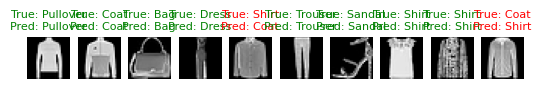


Total Misclassified Samples: 2 / 10


In [53]:
def evaluate_random_samples(model, test_data_loader, class_labels, num_samples=10):
    # 학습된 모델 로드
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    model.eval()

    # 테스트 데이터에서 10개의 샘플을 랜덤으로 선택
    test_images, test_labels = [], []
    for inputs, targets in test_data_loader:
        test_images.extend(inputs)
        test_labels.extend(targets)
        if len(test_images) >= 10000:  # FashionMNIST 테스트 데이터는 10,000개
            break

    # 10개 샘플을 랜덤 선택
    indices = random.sample(range(len(test_images)), num_samples)
    random_images = [test_images[i] for i in indices]
    random_labels = [test_labels[i] for i in indices]

    # 분류 예측 및 시각화
    incorrect_count = 0  # 틀린 예측 카운트
    for idx, (image, label) in enumerate(zip(random_images, random_labels)):
        image = image.to(device).unsqueeze(0)  # 배치 차원 추가
        label = label.to(device)

        # 모델 예측
        with torch.no_grad():
            output = model(image)
            predicted_label = output.argmax(dim=1).item()

        # 이미지 출력
        plt.subplot(1, num_samples, idx + 1)
        plt.imshow(ToPILImage()(image.cpu().squeeze()), cmap="gray")
        plt.axis("off")
        plt.title(f"True: {class_labels[label.item()]}\nPred: {class_labels[predicted_label]}",
                  fontsize=8, color="green" if predicted_label == label.item() else "red")

        # 틀린 예측 해석
        if predicted_label != label.item():
            incorrect_count += 1
            print(f"Misclassified Sample {idx + 1}:")
            print(f"  True Label: {class_labels[label.item()]}")
            print(f"  Predicted: {class_labels[predicted_label]}")
            print("  Reason (Possible): The model may have misinterpreted fine details in the image, "
                  "or the class may have similar features to another class. ")
            print("-" * 50)

    plt.show()

    print(f"\nTotal Misclassified Samples: {incorrect_count} / {num_samples}")


# 실행 예시
if __name__ == "__main__":
    # Class labels for FashionMNIST
    class_labels = [
        "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
        "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
    ]


    # 모델 로드 (이미 학습된 모델을 가져옵니다)
    model = get_vgg_model()  # 혹은 get_googlenet_model()
    model = load_model(model, save_path="best_model.pth")

    # 샘플 테스트 데이터 분류 및 결과 확인
    evaluate_random_samples(model, test_data_loader, class_labels, num_samples=10)

5번과 같은 경우 아마 팔다리의 실루엣이 보이고, 면적이 넓은것으로 보아 코트는 대부분이 넓을 것이라 생각해 셔츠를 코트로 예측하지 않았나 생각된다.

10번과 같은 경우 코트지만 크게 넓지 않은 면적과 팔다리가 비교적 잘 드러나는 특징으로 인해 셔츠로 예측되지 않았나 생각된다.